# Reconstruction from transmittance


In [1]:
import torch
import rendervous as rdv
import matplotlib.pyplot as plt
import rendervous.datasets as datasets
from tqdm import tqdm


density_scale = 5.0
cloud = datasets.Volumes.disney_cloud.to(rdv.device()) * density_scale
bmin, bmax = rdv.normalized_box(cloud)

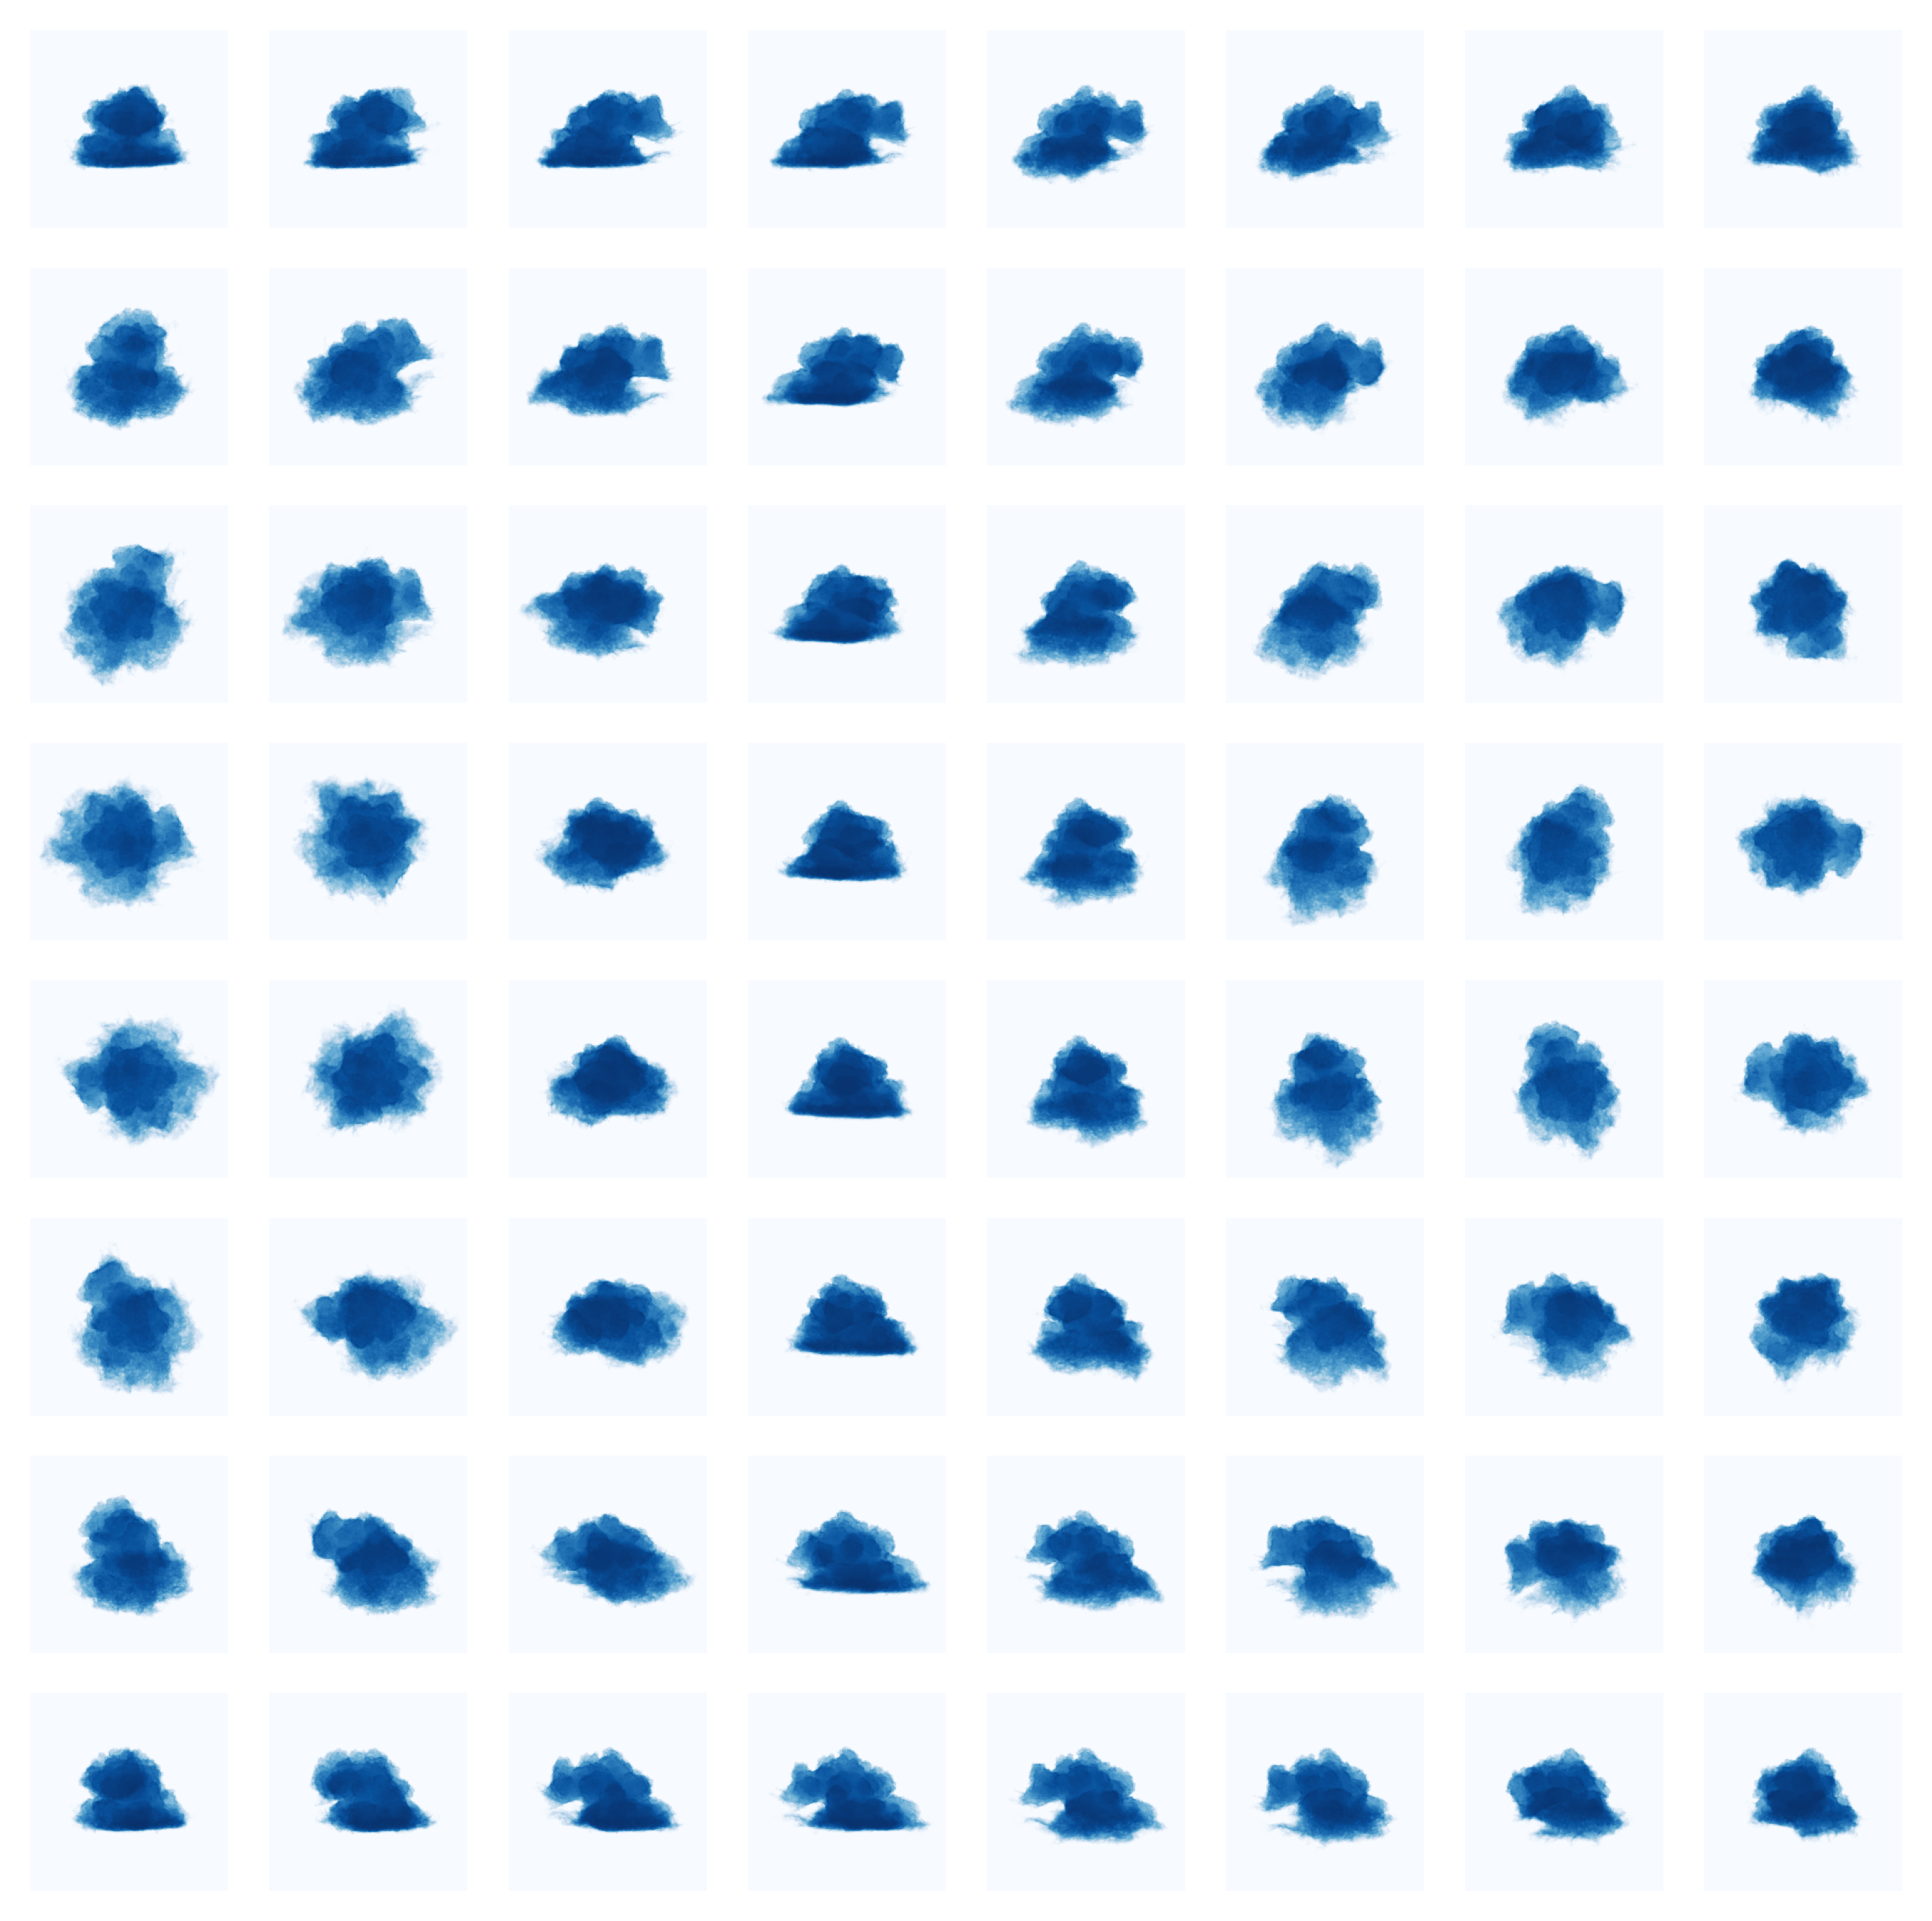

In [2]:
N = 8
training_poses = rdv.oct_camera_poses(N, radius=3.0)
training_camera = rdv.PerspectiveCameraSensor(256, 256, training_poses)
training_transmittance_field = rdv.GridDDATransmittance(rdv.Grid3D(cloud, bmin, bmax), rdv.ray_box_intersection[bmin, bmax])
reference_images = training_camera.capture(training_transmittance_field)

fig, axes = plt.subplots(N, N, figsize=(N, N), dpi=512)
for i in range(N):
    for j in range(N):
        axes[i,j].imshow(reference_images[i*8+j].cpu(), cmap='Blues_r', vmin=0.0, vmax=1.0)
        axes[i,j].invert_yaxis()
        axes[i,j].axis('off')
plt.show()

In [3]:
rec_camera = rdv.PerspectiveCameraSensor(256, 256, training_poses, jittered=True)

rec_tensor = torch.nn.Parameter(torch.zeros_like(cloud))

rec_grid = rdv.Grid3D(rec_tensor, bmin, bmax)

# rec_field = rdv.RatiotrackingTransmittance(rec_grid, rdv.ray_box_intersection[bmin, bmax], majorant=rdv.const[density_scale, 100000.0])

rec_field = rdv.GridDDATransmittance(rec_grid, rdv.ray_box_intersection[bmin, bmax])


STEPS = 200

opt = torch.optim.NAdam([rec_tensor], lr=0.2, betas=(0.9, 0.99))
sch = torch.optim.lr_scheduler.ExponentialLR(opt, 0.9995)
reconstruction_steps = tqdm(range(STEPS))
for step in reconstruction_steps:
    opt.zero_grad()
    inferred_images = rec_camera.capture(rec_field)
    loss = torch.nn.functional.huber_loss(
        reference_images,
        inferred_images,
        reduction='sum'
    )
    loss += rdv.total_variation(rec_tensor).sum() * 1e-3
    loss += rec_tensor.abs().sum() * 1e-4
    loss.backward()
    reconstruction_steps.set_description_str(f"Loss: {loss.item()}")
    opt.step()
    sch.step()
    with torch.no_grad():
        rec_tensor.clamp_min_(0.0)
    

Loss: 4800.0224609375: 100%|██████████| 200/200 [04:30<00:00,  1.35s/it] 


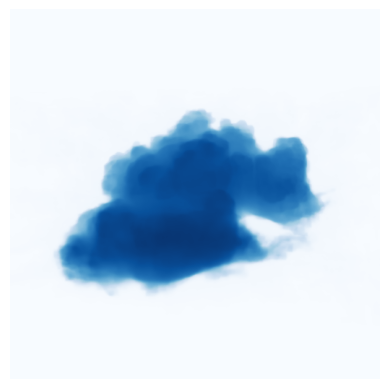

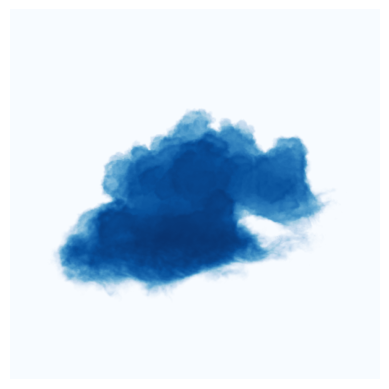

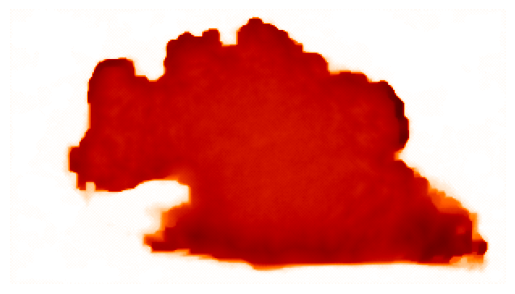

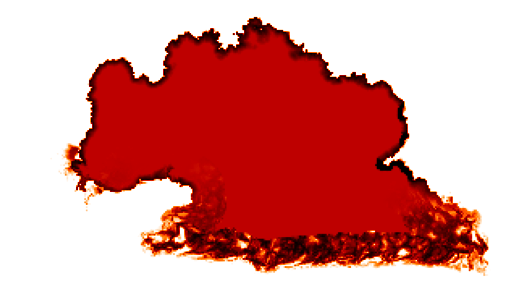

In [4]:
testing_poses = rdv.look_at_poses((-2.8, 0.2, -.4))
testing_camera = rdv.PerspectiveCameraSensor(512, 512, testing_poses)
test_field = rdv.GridDDATransmittance(rec_grid, rdv.ray_box_intersection[bmin, bmax])

with torch.no_grad():
    T = testing_camera.capture(test_field)
    plt.imshow(T[0].cpu(), cmap="Blues_r", vmin=0., vmax=1.0)
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.show()
    
    T = testing_camera.capture(training_transmittance_field)
    plt.imshow(T[0].cpu(), cmap="Blues_r", vmin=0., vmax=1.0)
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.show()
    
    plt.imshow(rec_tensor.cpu()[:,:,rec_tensor.shape[2]//2,0].T, cmap='gist_heat_r', vmin=0.0, vmax=density_scale)
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.show()
    
    plt.imshow(cloud.cpu()[:,:,cloud.shape[2]//2,0].T, cmap='gist_heat_r', vmin=0.0, vmax=density_scale)
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.show()